In [8]:
! nvidia-smi

Tue Mar 21 10:04:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    61W / 300W |   5397MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import lovely_tensors as lt
lt.monkey_patch()

def U(*shape):
    x = torch.rand(*shape)
    x = (x-0.5)*2.
    return x

In [12]:
device = 'cuda:0'

In [4]:
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss

# Define a Sinkhorn (~Wasserstein) loss between sampled measures
L = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

# Optimize tensor

In [6]:
lr = 1e1
x = torch.randn(1000, 1, requires_grad=True).cuda()
y = (U(2000, 1) + 2.).cuda()

000 loss=1.922580


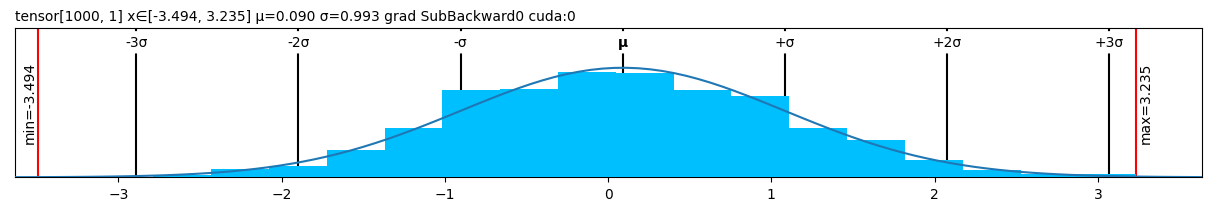

100 loss=0.248927
200 loss=0.033079
300 loss=0.004759
400 loss=0.000722
500 loss=0.000111


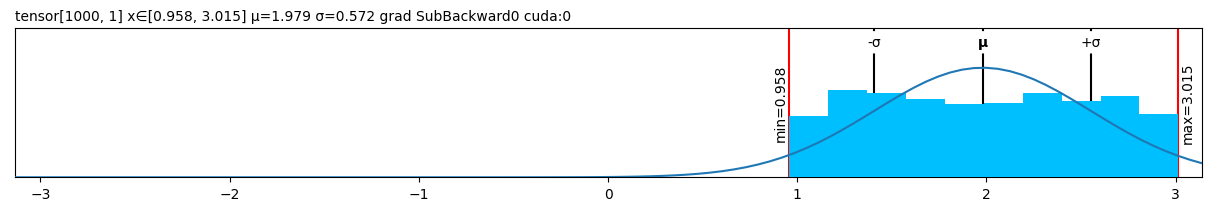

600 loss=0.000022
700 loss=0.000009
800 loss=0.000006
900 loss=0.000004
1000 loss=0.000002


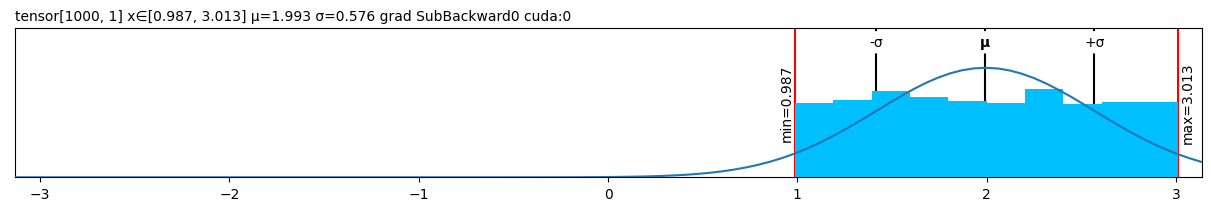

In [7]:
for i in range(1001):
    loss = L(x, y)  # By default, use constant weights = 1/number of samples
    g_x, = torch.autograd.grad(loss, [x])  # GeomLoss fully supports autograd!
    x = x - lr*g_x
    if i % 100 == 0:
        print(f'{i:03} loss={loss.item():.6f}')
    if i % 500 == 0:
        display(x.plt)

# Optimize weights through non-linearity

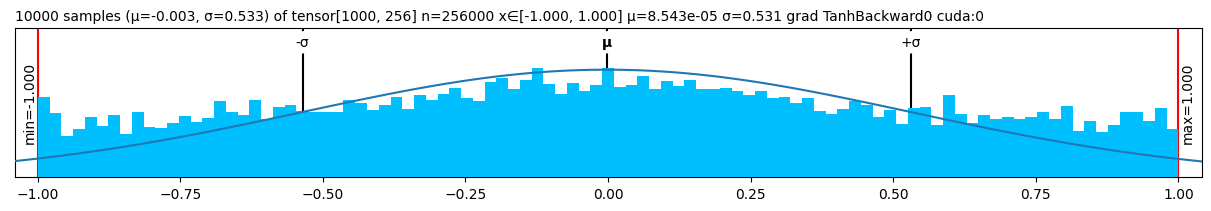

In [43]:
x = U(1000, 2).to(device)
w = torch.randn(2, 256).to(device)
w.requires_grad = True
y = x@w
y = y.tanh()
y.plt

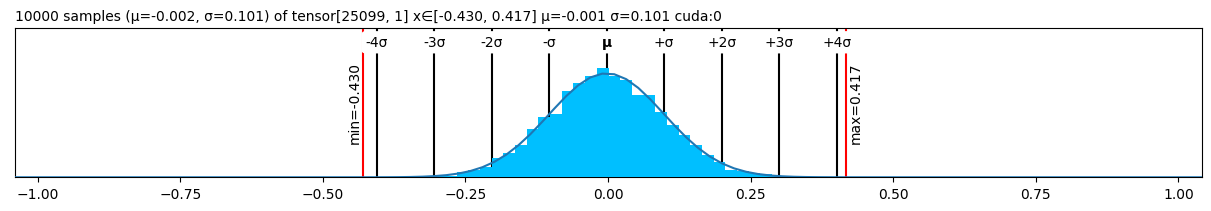

In [41]:
target_distribution = torch.randn(25_099).to(device).reshape(-1, 1)*0.1
target_distribution.plt

000 loss=0.000025


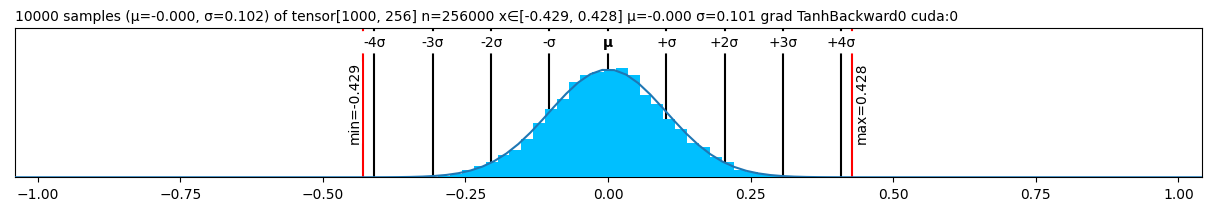

001 loss=0.000025
002 loss=0.000025
003 loss=0.000025
004 loss=0.000025
005 loss=0.000025


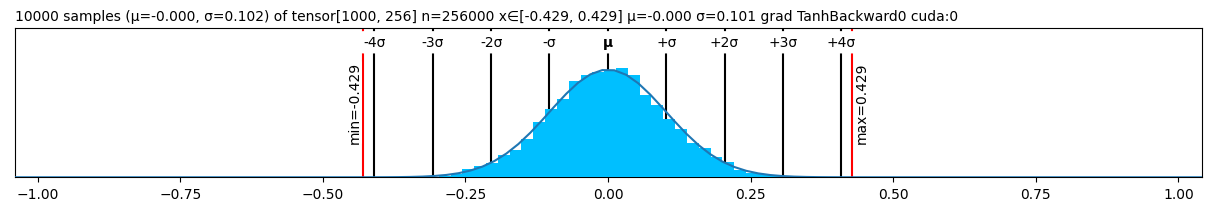

006 loss=0.000025
007 loss=0.000025
008 loss=0.000025
009 loss=0.000024
010 loss=0.000024


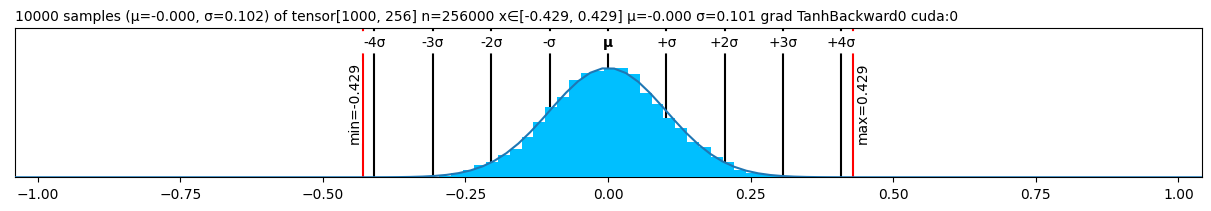

011 loss=0.000024
012 loss=0.000024
013 loss=0.000024
014 loss=0.000024
015 loss=0.000024


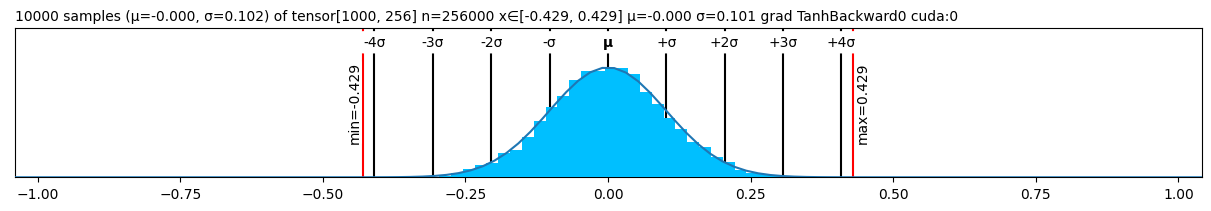

In [45]:
lr = 1e1

for i in range(1001):
    y = x@w
    y = y.tanh()

    loss = L(10*y.reshape(-1, 1), 10*target_distribution)
    g_w, = torch.autograd.grad(loss, [w])
    w = w - lr*g_w
    if i % 1 == 0:
        print(f'{i:03} loss={loss.item():.6f}')
    if i % 5 == 0:
        display(y.plt)
        
    if i == 15:
        break

# Stable split net activations

In [80]:
def init_splitact_Wb_randn(insize, outsize, device):
    W = torch.randn(insize, outsize*4, device=device)
    b = torch.randn(outsize*4, device=device)
    return W, b

def init_splitact_Wb_pytorch(insize, outsize, device):
    ksqrt = (1/insize)**0.5
    W = (torch.rand(insize, outsize*4, device=device) - 0.5) * 2 * ksqrt
    b = 0.*(torch.rand(outsize*4, device=device) - 0.5) * 2 * ksqrt

    return W, b

def init_splitact_Wb(insize, outsize, device):
    return init_splitact_Wb_pytorch(insize, outsize, device)

In [81]:
def splitlayer_forward(input_h, W, b):
    hpreact = input_h@W + b
    hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos = hpreact.chunk(4, dim=-1)
    htanh, hsigmoid, hsin, hcos = hpreact_tanh.tanh(), hpreact_sigmoid.sigmoid(), hpreact_sin.sin(), hpreact_cos.cos()
    h = htanh*hsigmoid*hsin*hcos

    return h, {'internal_activations': [hpreact, hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos, htanh, hsigmoid, hsin, hcos]}

In [97]:
hsize = 128
W1, b1 = init_splitact_Wb(128, hsize, device)
W2, b2 = init_splitact_Wb(hsize, hsize, device)
W3, b3 = init_splitact_Wb(hsize, hsize, device)

parameters = [W1, b1, W2, b2, W3, b3]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

198144


In [84]:
encoded_input = U(1000, 128).to(device)

In [95]:
h1, layer1_acts = splitlayer_forward(encoded_input, W1, b1)
h2, layer2_acts = splitlayer_forward(h1, W2, b2)
h3, layer3_acts = splitlayer_forward(h2, W3, b3)

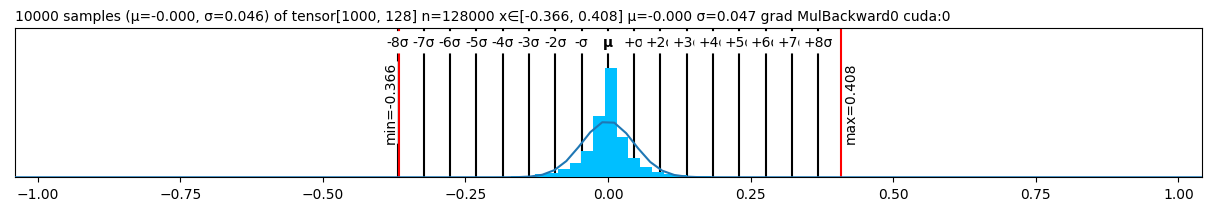

In [86]:
h1.plt

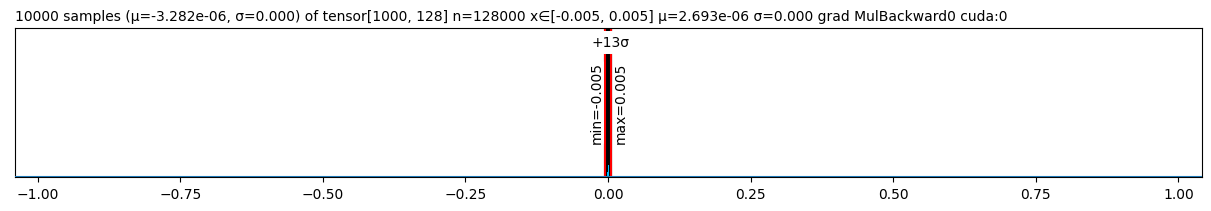

In [87]:
h2.plt

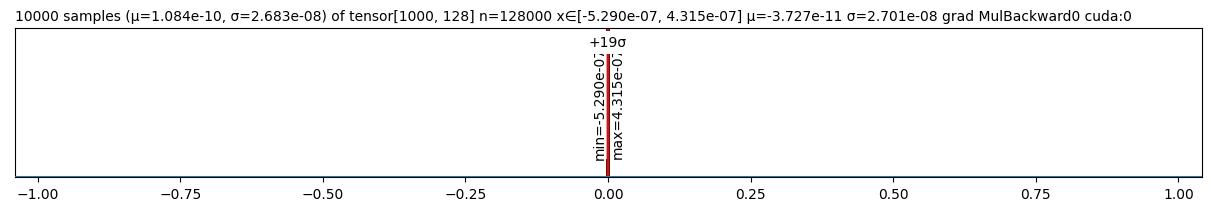

In [88]:
h3.plt

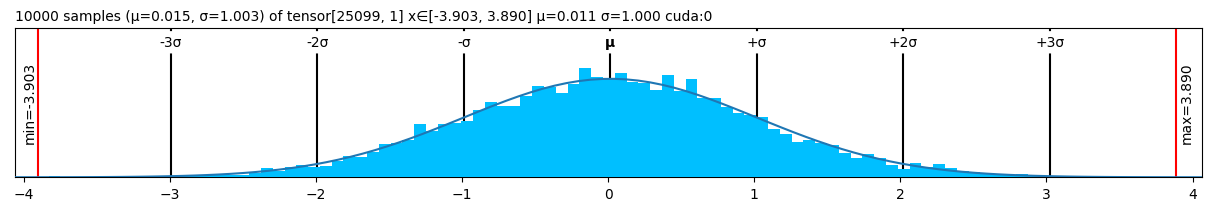

In [94]:
target_distribution = torch.randn(25_099).to(device).reshape(-1, 1)*1.

def diff_loss(x, y): return L(10*x.reshape(-1, 1), 10*y.reshape(-1, 1))
def normal_loss(x): return L(10*x.reshape(-1, 1), 10*target_distribution)


target_distribution.plt

In [104]:
hsize = 128
W1, b1 = init_splitact_Wb(128, hsize, device)
W2, b2 = init_splitact_Wb(hsize, hsize, device)
W3, b3 = init_splitact_Wb(hsize, hsize, device)

parameters = [W1, b1, W2, b2, W3, b3]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

198144


000 loss=146.453003


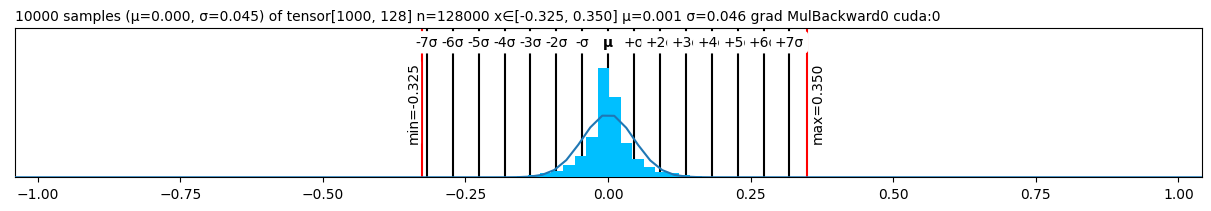

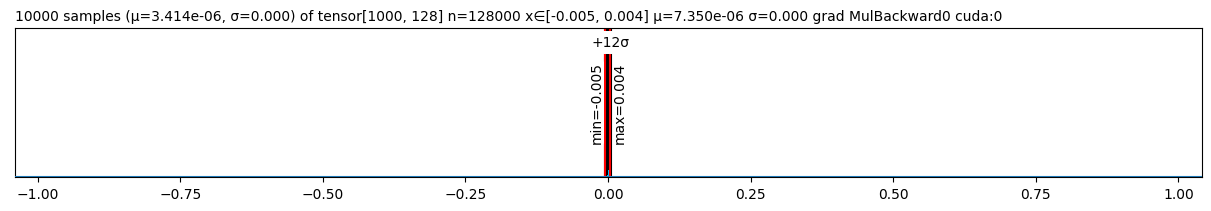

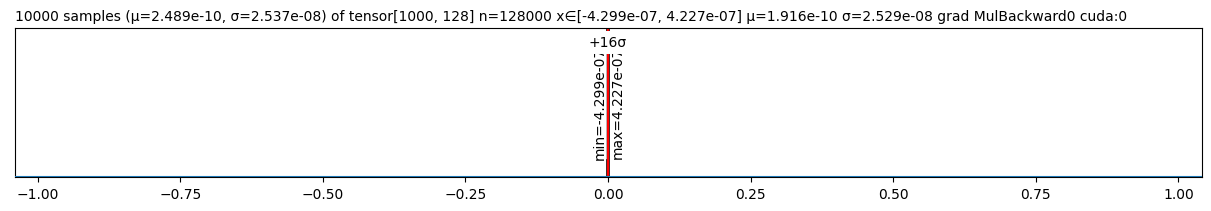

001 loss=145.419662
002 loss=145.437347
003 loss=145.311218
004 loss=145.250549
005 loss=145.173477
006 loss=145.095947
007 loss=144.999710
008 loss=144.869049
009 loss=144.726501
010 loss=144.527527
011 loss=144.472076
012 loss=144.761414
013 loss=145.081146
014 loss=142.145020
015 loss=134.765747


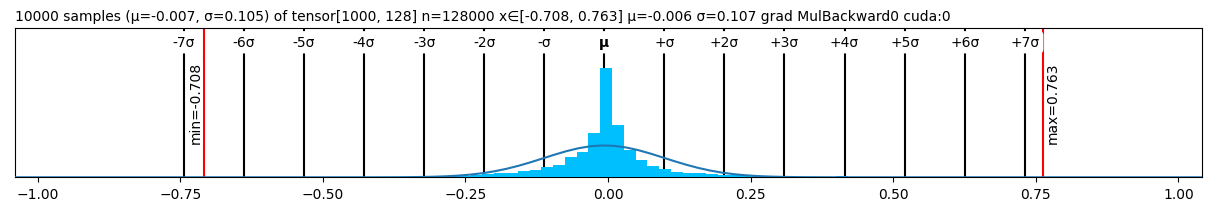

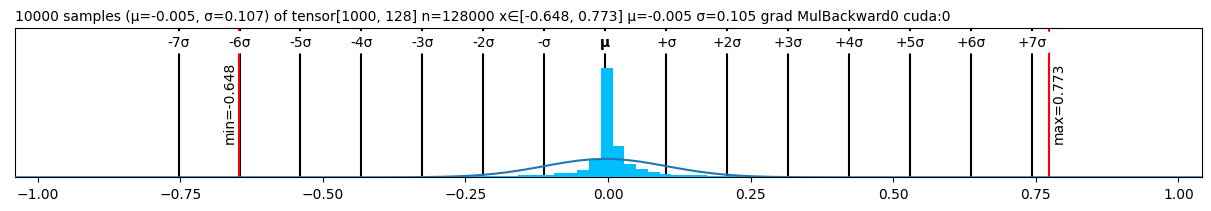

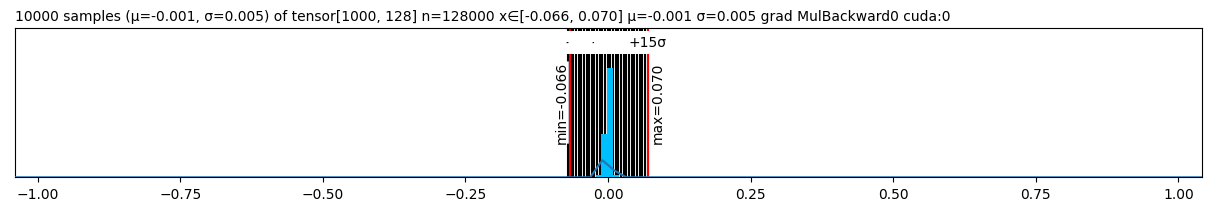

016 loss=93.856865
017 loss=103.317139
018 loss=96.943558
019 loss=88.434540
020 loss=84.422295
021 loss=80.445892
022 loss=77.571671
023 loss=77.334366
024 loss=75.613464
025 loss=73.841591
026 loss=73.030266
027 loss=71.428162
028 loss=69.745682
029 loss=70.175446
030 loss=68.850540


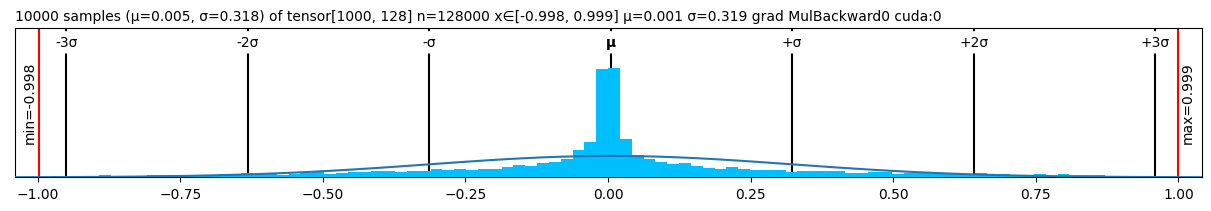

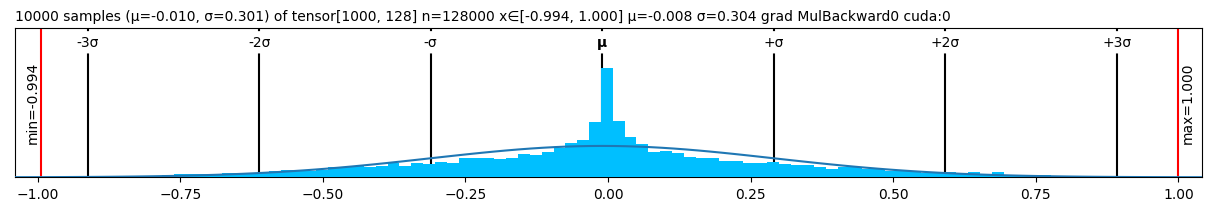

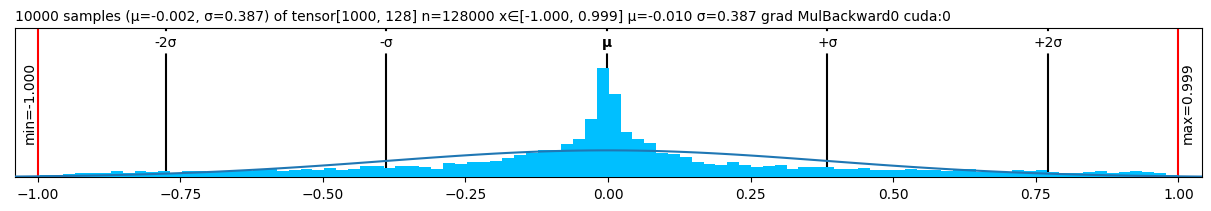

031 loss=68.248360
032 loss=67.615051
033 loss=67.171661
034 loss=66.886261
035 loss=66.481934
036 loss=65.779755
037 loss=65.664291
038 loss=65.047585
039 loss=64.925049
040 loss=64.113503
041 loss=63.769444
042 loss=63.995777
043 loss=63.749794
044 loss=63.457840
045 loss=62.601662


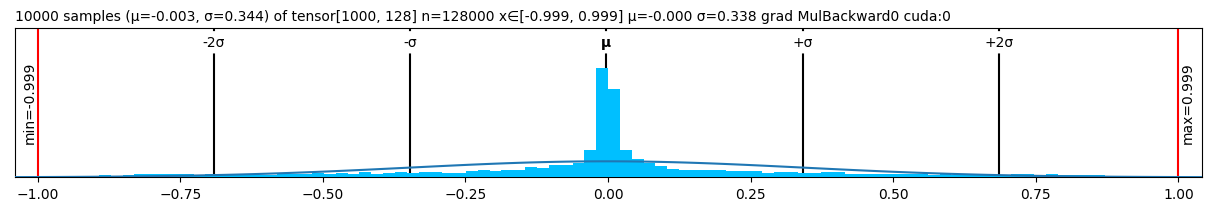

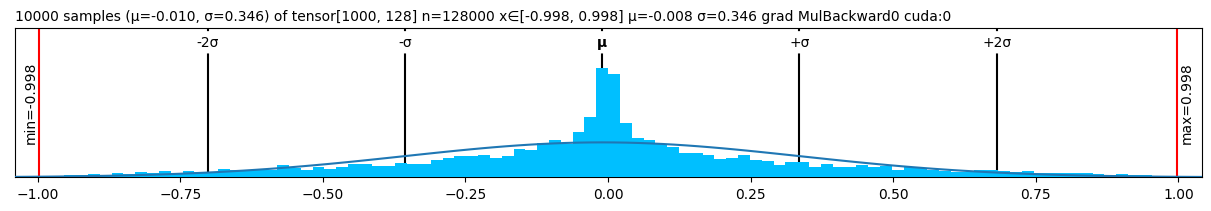

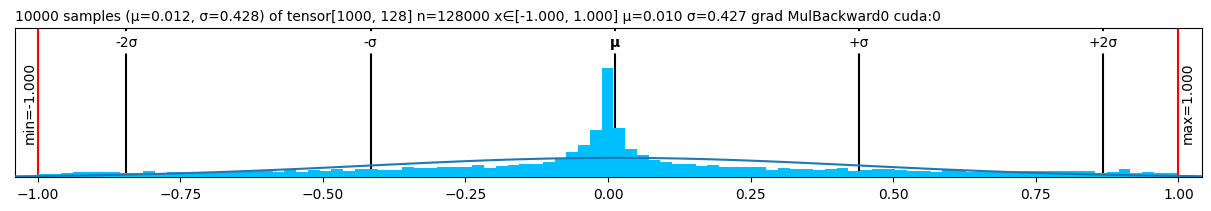

046 loss=62.773991
047 loss=62.496338
048 loss=61.471958
049 loss=62.112270
050 loss=61.514431
051 loss=61.410934
052 loss=61.120697
053 loss=61.245350
054 loss=61.375729
055 loss=60.633224
056 loss=61.020706
057 loss=60.310272
058 loss=60.258011
059 loss=59.864182
060 loss=59.317322


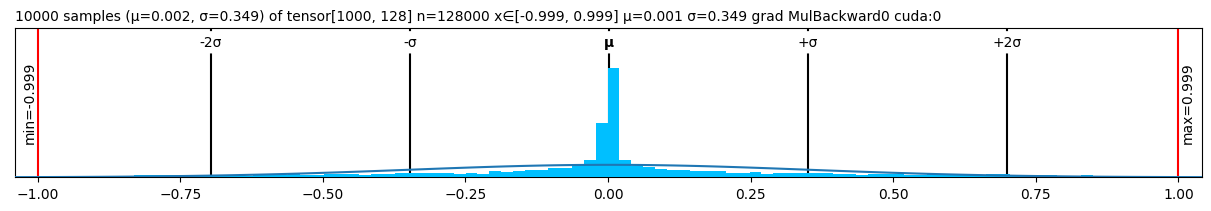

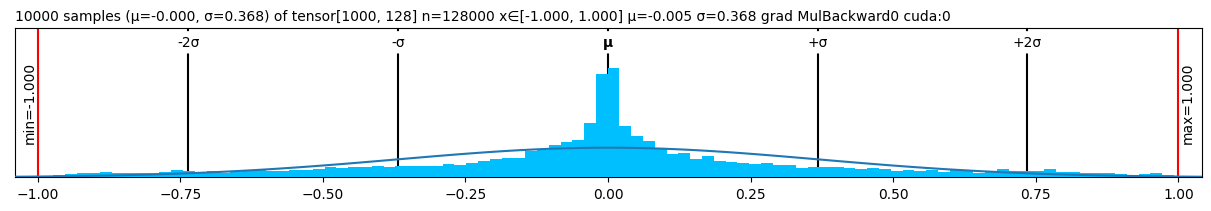

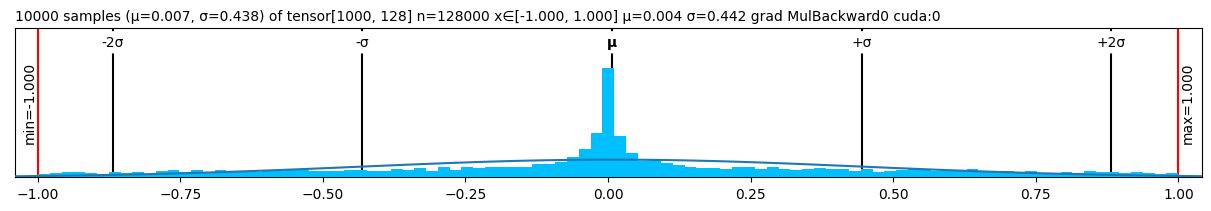

061 loss=59.244534
062 loss=59.286423
063 loss=59.015610
064 loss=58.976582
065 loss=58.992081
066 loss=59.047203
067 loss=58.885498
068 loss=58.714481
069 loss=58.941895
070 loss=58.791340
071 loss=58.774994
072 loss=57.729851
073 loss=57.891304
074 loss=57.848518
075 loss=57.627502


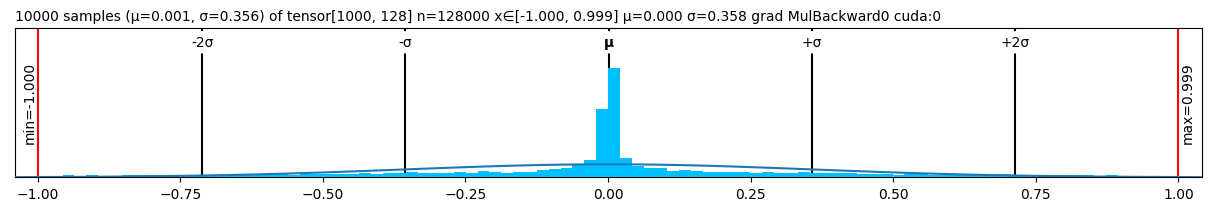

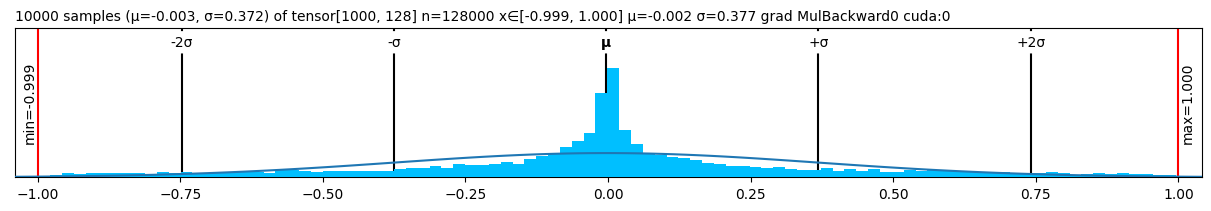

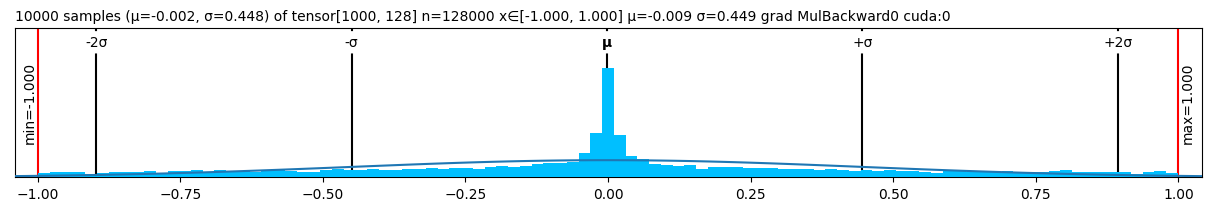

076 loss=57.876656
077 loss=58.072166
078 loss=57.768013
079 loss=58.057842
080 loss=57.923321
081 loss=56.704998
082 loss=57.769485
083 loss=57.299156
084 loss=57.433434
085 loss=57.129215
086 loss=56.979496
087 loss=56.711159
088 loss=56.948425
089 loss=57.029251
090 loss=56.319977


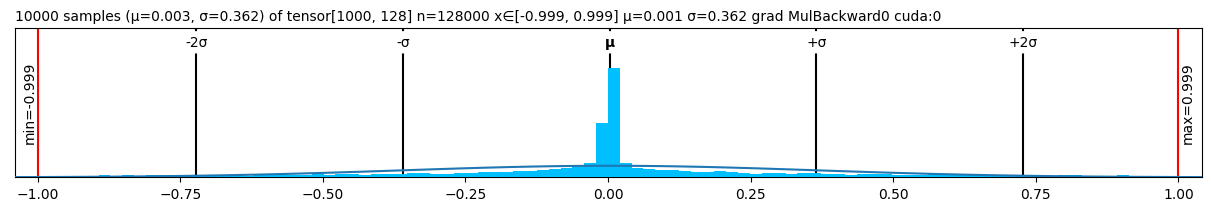

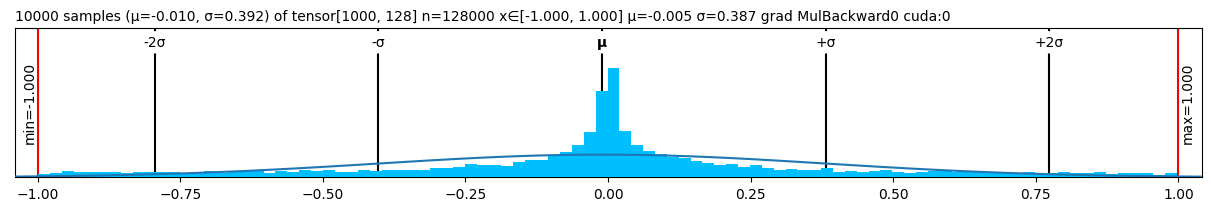

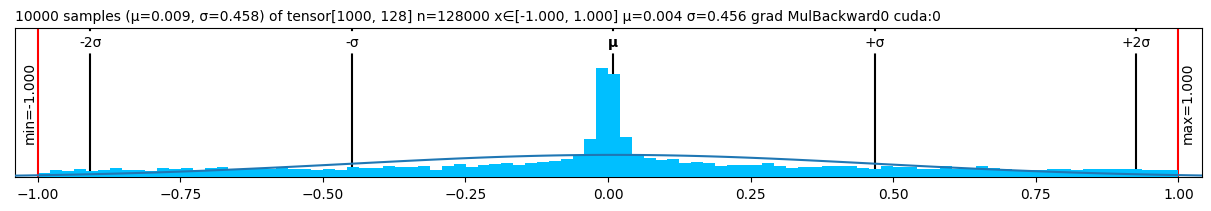

091 loss=56.663311
092 loss=57.061935
093 loss=56.553082
094 loss=56.443890
095 loss=56.796253
096 loss=56.750771
097 loss=55.946388
098 loss=56.049080
099 loss=56.089226
100 loss=56.255806
101 loss=56.365215
102 loss=50.924320
103 loss=50.446922
104 loss=50.497044
105 loss=50.794830


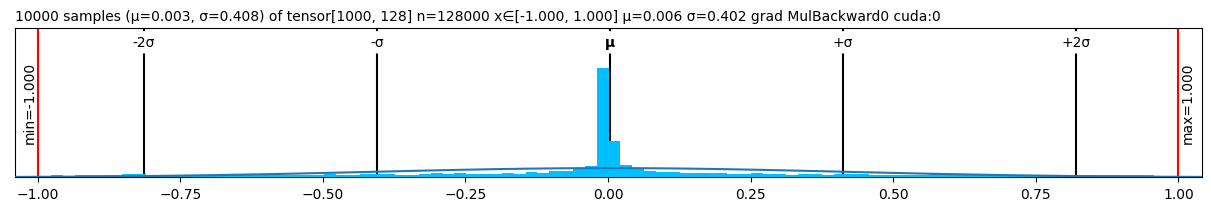

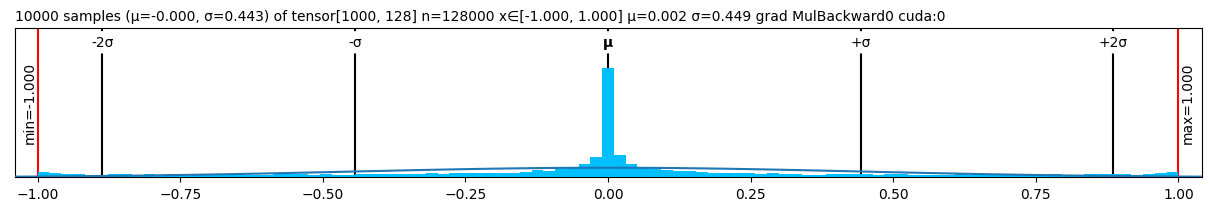

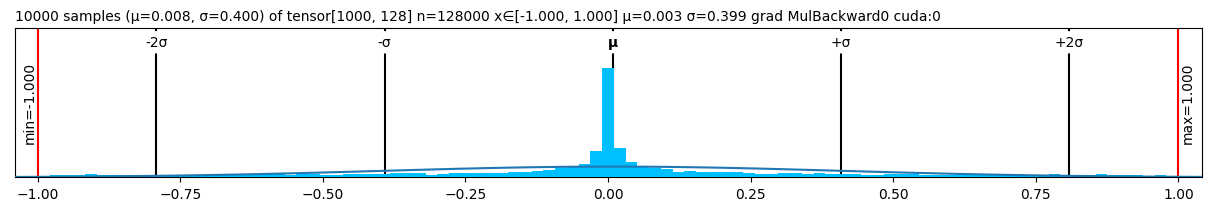

106 loss=50.849495
107 loss=51.667156
108 loss=49.876923
109 loss=49.259323
110 loss=48.547478
111 loss=47.871529
112 loss=47.675522
113 loss=47.075577
114 loss=46.307037
115 loss=45.541367
116 loss=44.866199
117 loss=44.306419
118 loss=43.908398
119 loss=43.312386
120 loss=42.897346


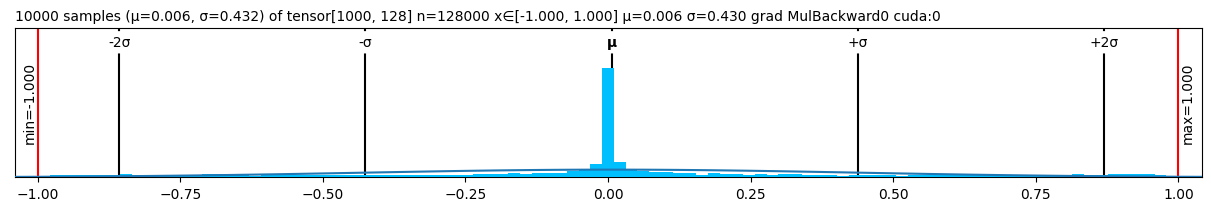

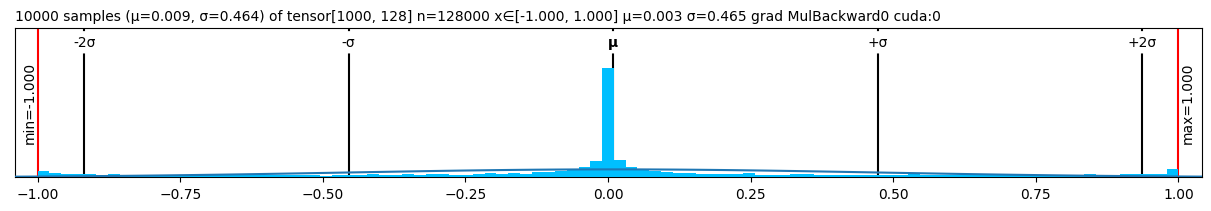

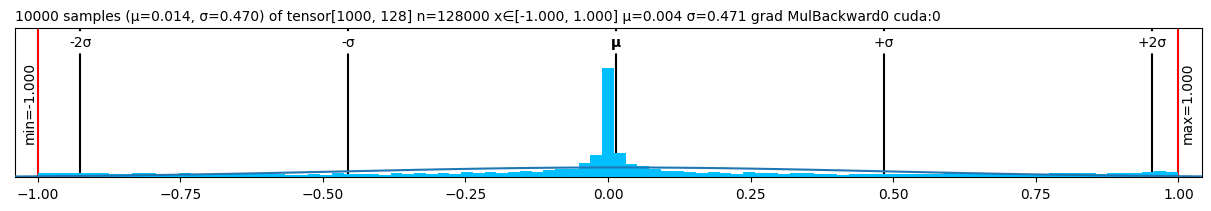

121 loss=42.314411
122 loss=42.205605
123 loss=41.985294
124 loss=42.437645
125 loss=42.636539
126 loss=43.200520
127 loss=42.254990
128 loss=42.186008
129 loss=42.327324
130 loss=42.561203
131 loss=41.700718
132 loss=42.195915
133 loss=42.477207
134 loss=42.706116
135 loss=41.367836


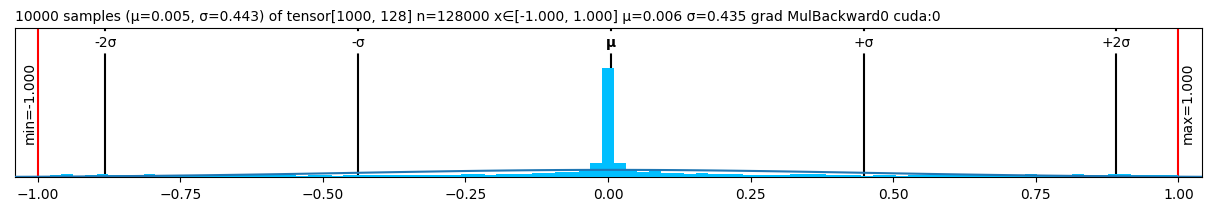

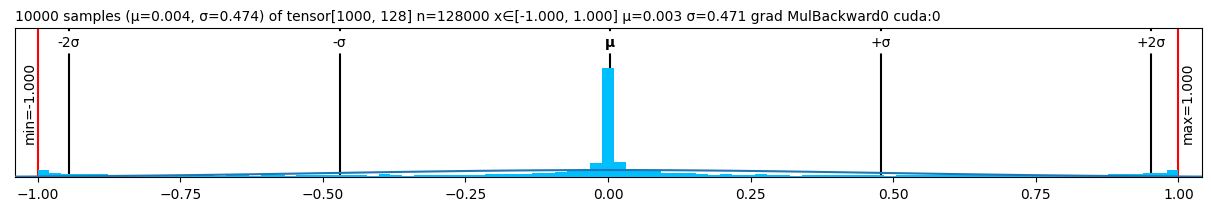

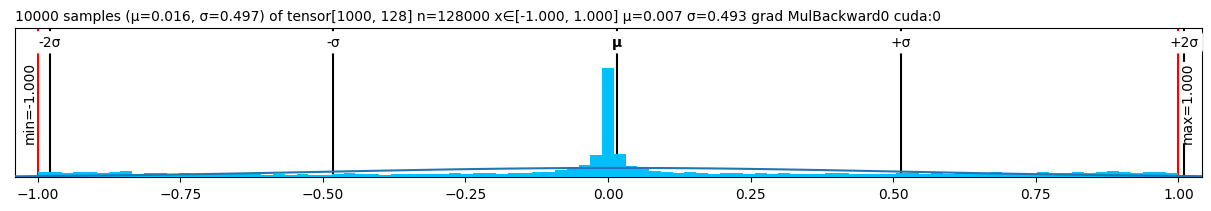

136 loss=41.319298
137 loss=40.818222
138 loss=40.955757
139 loss=40.564735
140 loss=42.091457
141 loss=42.991310
142 loss=42.560535
143 loss=41.198925
144 loss=40.382065
145 loss=39.726505
146 loss=39.944267
147 loss=39.987877
148 loss=41.075878
149 loss=41.787029
150 loss=41.279034


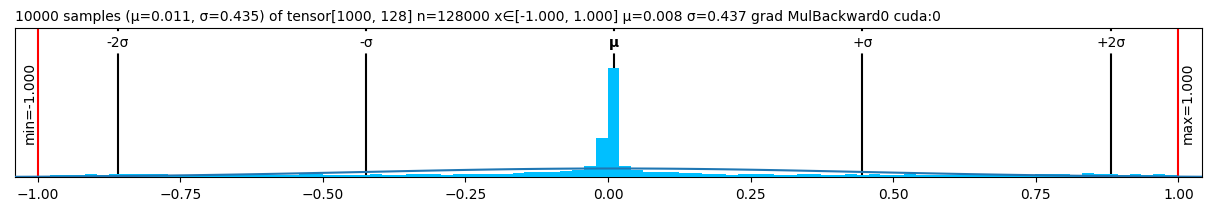

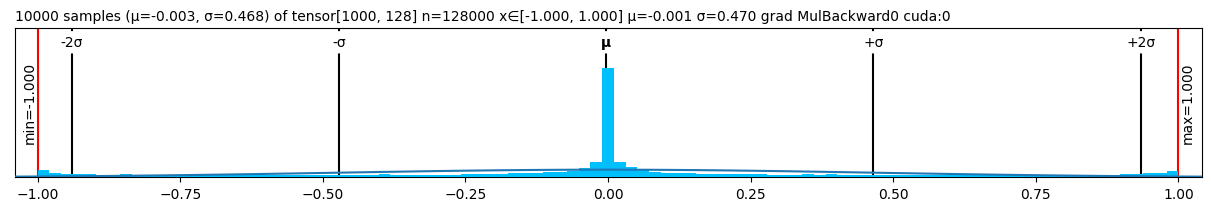

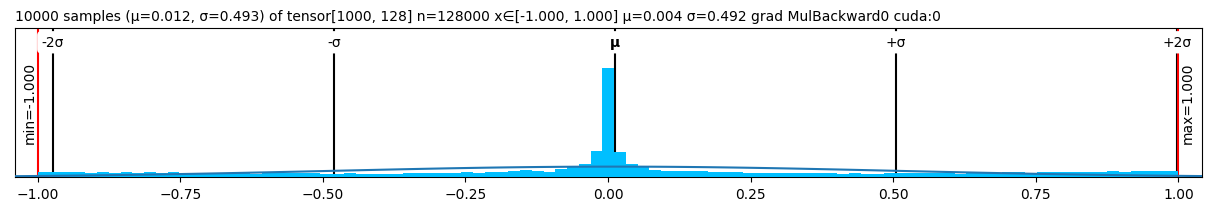

151 loss=40.187763
152 loss=39.833939
153 loss=39.497677
154 loss=39.478569
155 loss=39.413689
156 loss=40.819801
157 loss=40.903782
158 loss=41.187943
159 loss=40.452854
160 loss=40.842987
161 loss=40.521805
162 loss=39.940491
163 loss=39.102074
164 loss=39.175858
165 loss=38.743977


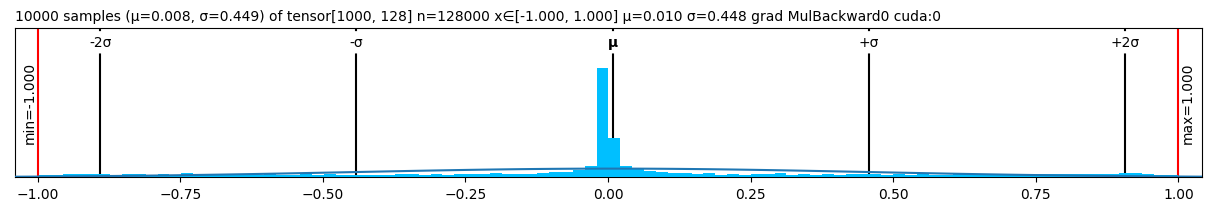

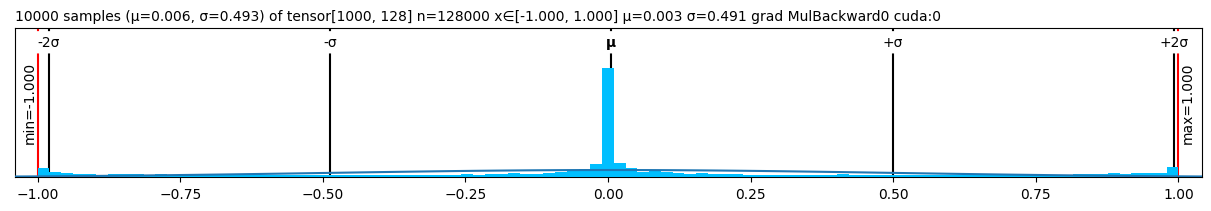

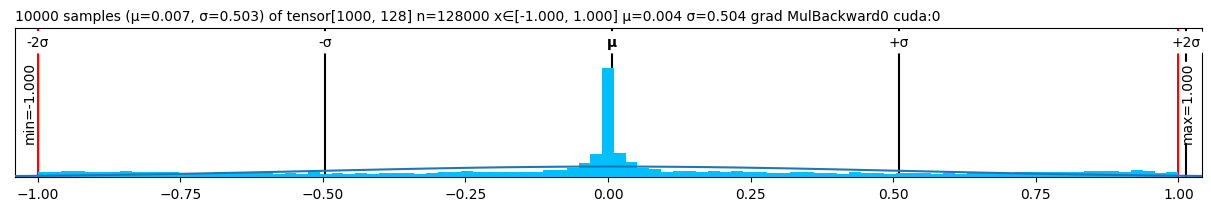

166 loss=39.209053
167 loss=38.759651
168 loss=39.395821
169 loss=39.081413
170 loss=39.435791
171 loss=39.086315
172 loss=39.017578
173 loss=38.308952
174 loss=38.786228
175 loss=39.192482
176 loss=40.107460
177 loss=39.381126
178 loss=39.359280
179 loss=38.702232
180 loss=39.114403


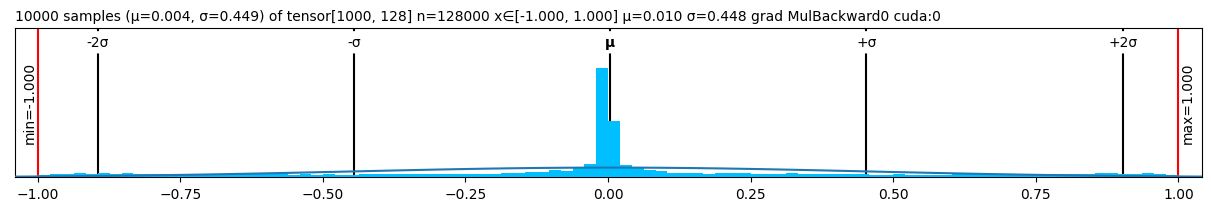

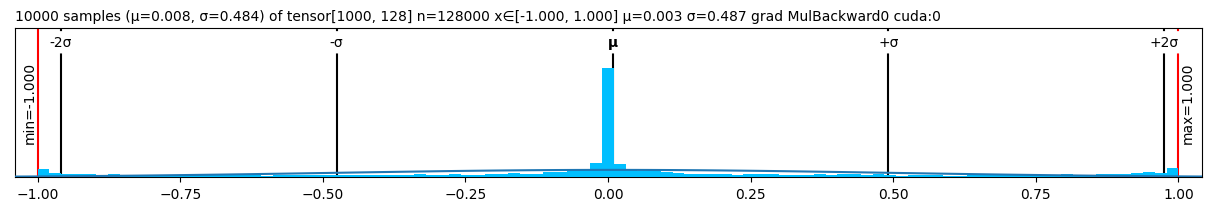

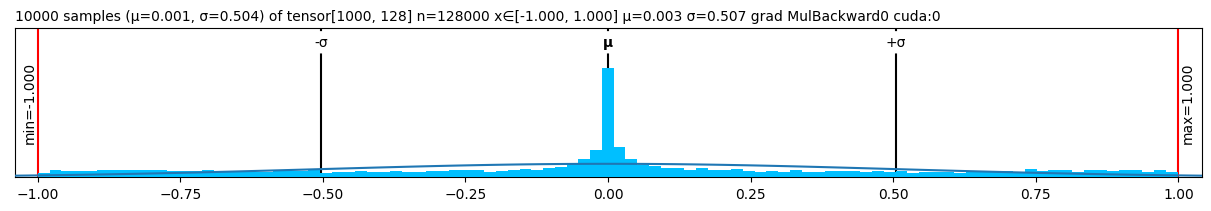

181 loss=38.590557
182 loss=38.641396
183 loss=38.444256
184 loss=38.523140
185 loss=37.944561
186 loss=38.868179
187 loss=38.688606
188 loss=39.099312
189 loss=38.756645
190 loss=38.743198
191 loss=38.205872
192 loss=37.681568
193 loss=36.889812
194 loss=36.854111
195 loss=37.067001


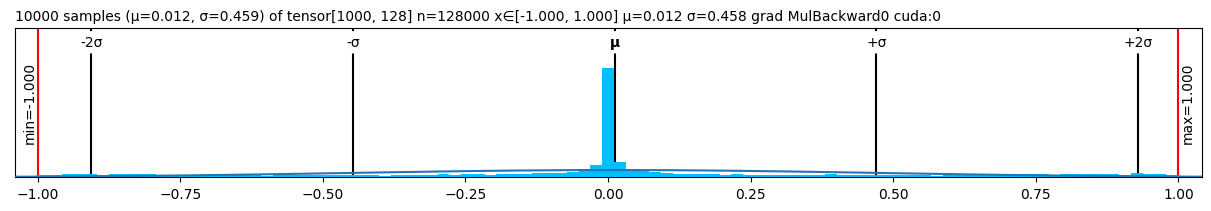

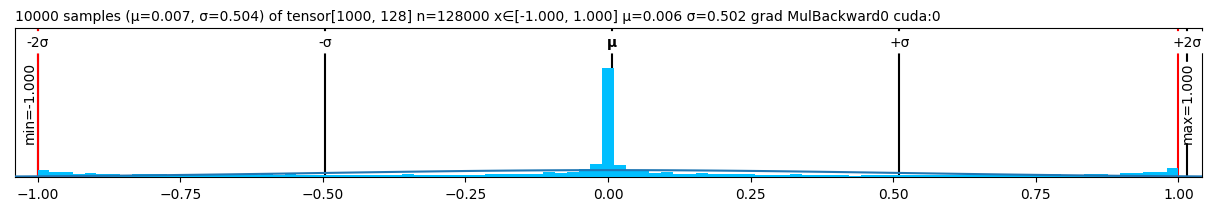

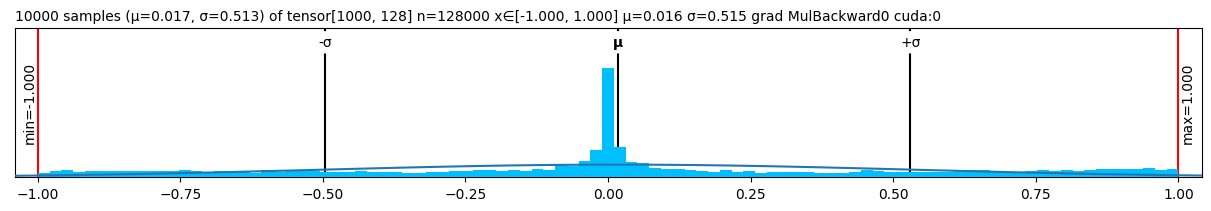

196 loss=39.439011
197 loss=39.415855
198 loss=39.278267
199 loss=38.079811
200 loss=37.890625
201 loss=37.615265
202 loss=37.167690
203 loss=36.665257
204 loss=37.208725
205 loss=36.861385
206 loss=37.542587
207 loss=37.404423
208 loss=37.637218
209 loss=37.294891
210 loss=37.497162


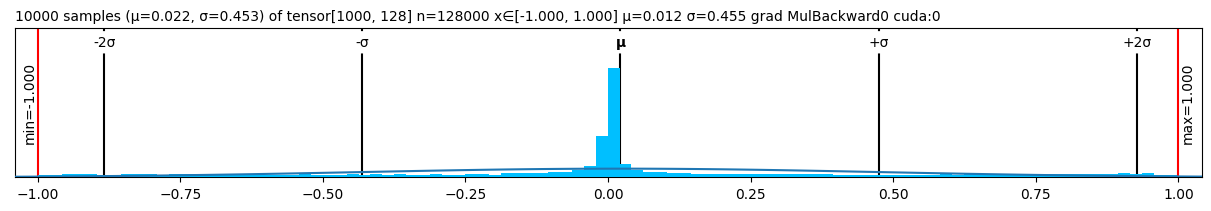

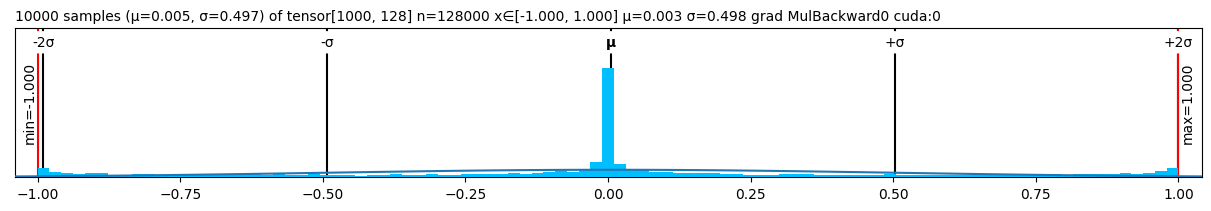

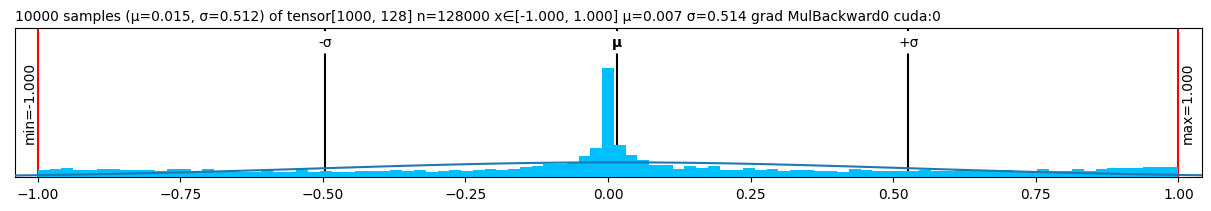

211 loss=37.180946
212 loss=37.651176
213 loss=37.410748
214 loss=37.167099
215 loss=36.904030
216 loss=37.240364
217 loss=36.853737
218 loss=37.539871
219 loss=37.113457
220 loss=37.537525
221 loss=37.160805
222 loss=36.825291
223 loss=36.183594
224 loss=36.452160
225 loss=36.586727


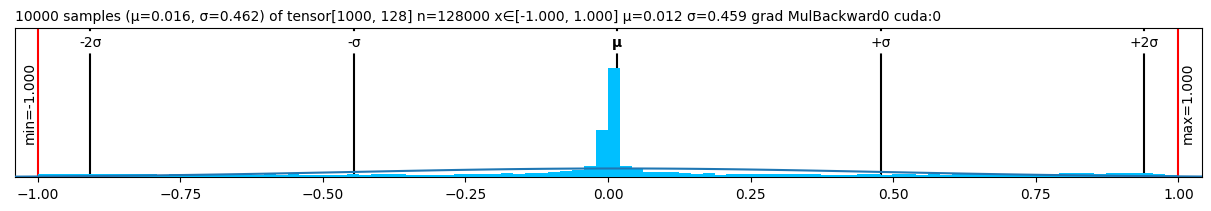

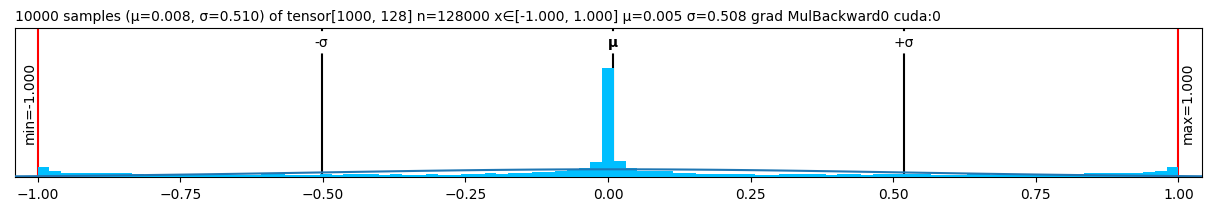

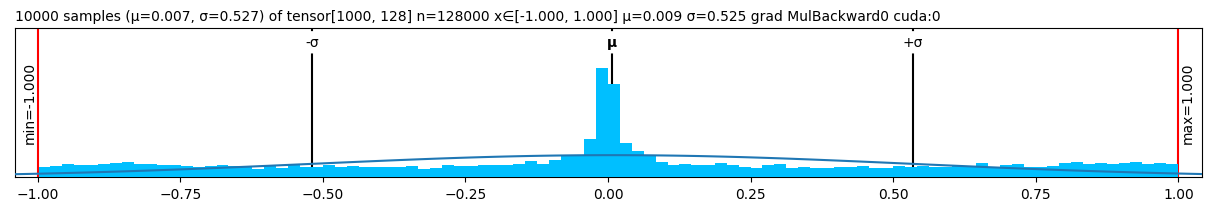

226 loss=37.392483
227 loss=37.292831
228 loss=37.459785
229 loss=37.447914
230 loss=37.018337
231 loss=36.865063
232 loss=36.755470
233 loss=36.959896
234 loss=36.683807
235 loss=36.517822
236 loss=36.438385
237 loss=36.424709
238 loss=37.063171
239 loss=36.639259
240 loss=37.055656


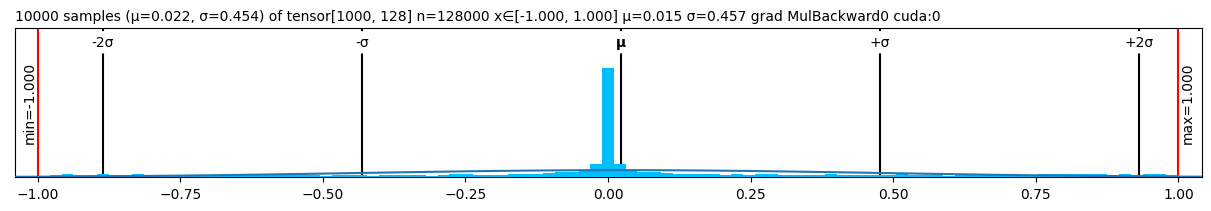

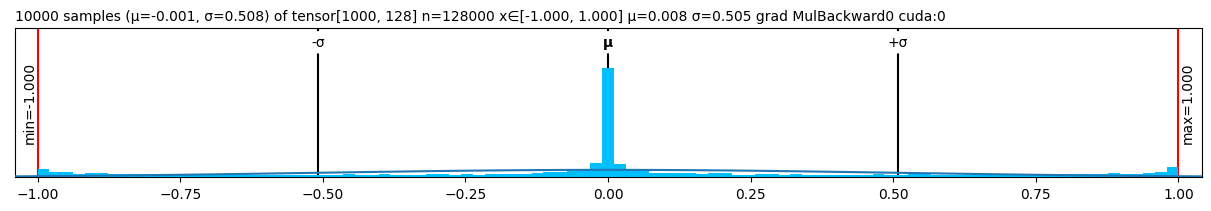

KeyboardInterrupt: 

In [105]:
lr = 1e1

for i in range(1001):

    h1, layer1_acts = splitlayer_forward(encoded_input, W1, b1)
    h2, layer2_acts = splitlayer_forward(h1, W2, b2)
    h3, layer3_acts = splitlayer_forward(h2, W3, b3)

    loss = 5.*diff_loss(h1, h2) + 5.*diff_loss(h2, h3) + 5.*diff_loss(h1, h3) + normal_loss(h3) + normal_loss(h2) + normal_loss(h1)
    g_w1, g_w2, g_w3 = torch.autograd.grad(loss, [W1, W2, W3])
    W1 = W1 - lr*g_w1
    W2 = W2 - lr*g_w2
    W3 = W3 - lr*g_w3
    if i % 1 == 0:
        print(f'{i:03} loss={loss.item():.6f}')
    if i % 15 == 0:
        display(h1.plt)
        display(h2.plt)
        display(h3.plt)
        
    if i == 100:
        lr = lr / 10

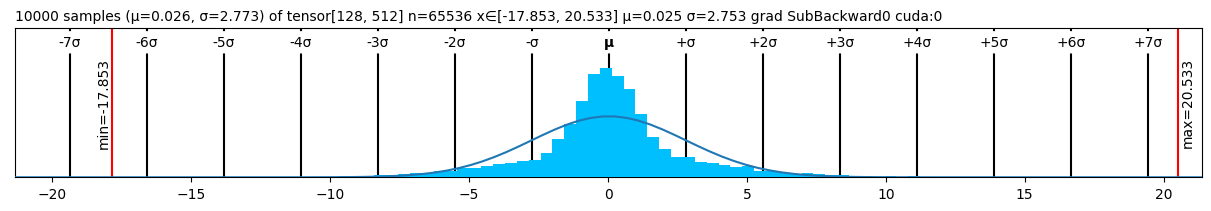

In [110]:
W1.plt

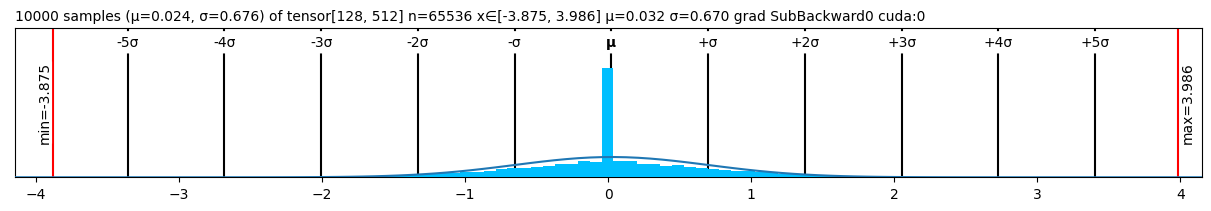

In [111]:
W2.plt

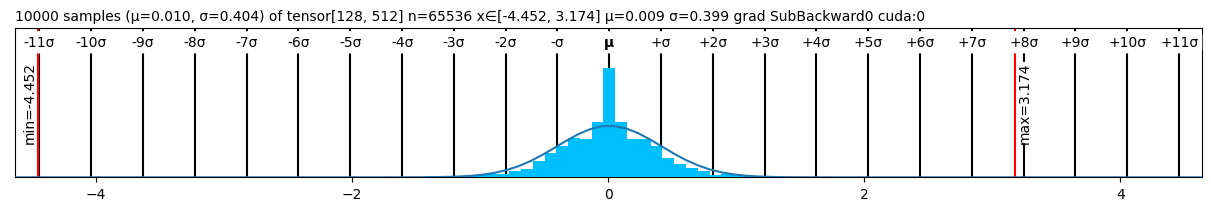

In [112]:
W3.plt

# Derive stable sin distribution

In [52]:
x = 30*U(1000, 2).to(device)
w1 = torch.randn(2, 256).to(device)
w1.requires_grad = True

w2 = torch.randn(256, 256).to(device)

a1 = (x@w1).tanh()
a2 = (a1@w2).tanh()

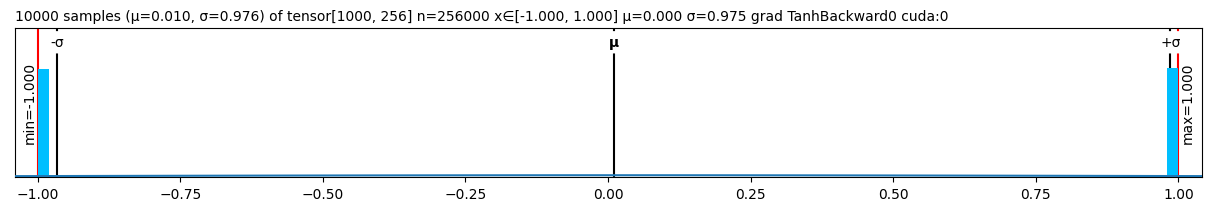

In [53]:
a1.plt

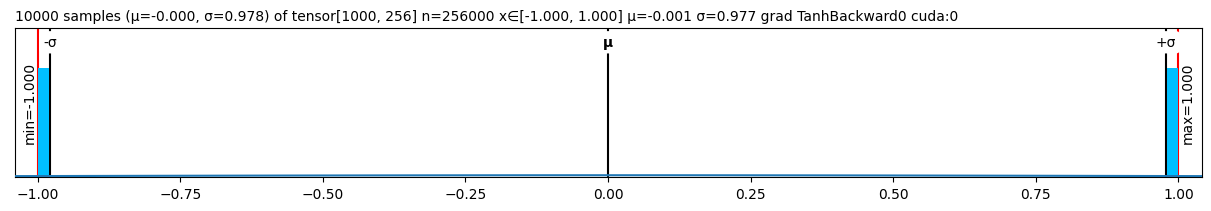

In [54]:
a2.plt